In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import datetime
import glob
import pandas as pd
from sklearn.linear_model import LogisticRegression
%matplotlib inline

daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')

/home/brad/DailyLog/20200123/


In [2]:
# cond: -1 = different, 1 = same class

def extract_submatrix(mat, h, pos):
    x, y = pos
    return mat[x*h:(x+1)*h, y*h:(y+1)*h].flatten()


def build_lmm_dataset(div_matrix):
    n, _ = np.shape(div_matrix)
    h = int(n/8)
    
    LR_mask = np.zeros((n, n))
    LR_mask[0:2*h, 2*h:4*h] = 1
    LR_mask[2*h:4*h, 4*h:6*h] = 1
    LR_mask[0:2*h, 6*h:n] = 1
    LR_mask[4*h:6*h, 6*h:n] = 1
    LR_inds = np.nonzero(LR_mask)
    LR_data_full = div_matrix[LR_inds]
    LR_data = np.random.choice(LR_data_full, size=12*h*h)
    print(LR_data.shape)
    LR_condition = 12*h*h*['different']

    
    LL_blocks = [(0,1), (0,4), (0,5), (1,4), (1,5), (4,5)]
    RR_blocks = [(2,3), (2,6), (2,7), (3,6), (3,7), (6,7)]
    
    #LL_data = div_matrix[0:h, h:2*h].flatten()
    
    LL_data = np.concatenate(list(map(lambda pos: extract_submatrix(div_matrix, h, pos), LL_blocks)))
    LL_condition = len(LL_data)*['same']

    RR_data = np.concatenate(list(map(lambda pos: extract_submatrix(div_matrix, h, pos), RR_blocks)))
    #RR_data = div_matrix[2*h:3*h, 3*h:n].flatten()

    RR_condition = len(RR_data)*['same']

    
    dat_cat = np.concatenate((LL_data, LR_data.flatten(), RR_data))

    cond_cat = np.concatenate((LL_condition, LR_condition, RR_condition))
    
    df_out = pd.DataFrame(data={'JS': dat_cat,'cond': cond_cat})
    return df_out


def build_LRpredict_dataset(div_matrix):
    n, _ = div_matrix.shape
    print(n)
    LR_classes = np.concatenate([int(n/2)*['L'], int(n/2)*['R']])
    featmat = np.zeros((n, n-1))
    for trial in range(n):
        trialdat = div_matrix[trial, :]
        trialdat = np.concatenate([trialdat[0:trial], trialdat[trial+1:]])
        featmat[trial, :] = trialdat
    return (LR_classes, featmat)
    
    
def grouped_boxplot_with_scatter(data, order, ngroups=1, group_spacing=2, fig_path=None, colors=None, alphas=None, labels=None, positions=None, scatter_style=None, marker_size = 1, figsize=(5,4)):
    ''' From Zeke 
        Plot grouped boxplots
        data is in the form of a list of arrays, Ngroups*nboxes/group
    
    '''
    #colors = np.array(['pink', 'lightblue', 'lightgreen', 'pink', 'lightblue', 'lightgreen'])
    #alphas = np.array([0.25, 0.25, 0.25, 0.75, 0.75, 0.75])
    #labels = np.array(['CON/BOS', 'CON/Mot-wise', 'CON/Pc-wise', 'BOS/BOS', 'BOS/Mot-wise', 'BOS/Pc-wise'])
   
    nboxes = len(data)
    if alphas is None:
        alphas = np.array(nboxes*[1.0])
        
    dat_plot = [data[i] for i in order]
    
    # compute positions
    nboxes_per_group = int(int(len(data)) / int(ngroups))
    positions = np.arange(nboxes_per_group) +1
    for group in range(1, ngroups):
        positions = np.concatenate([positions, np.arange(max(positions)+group_spacing, max(positions)+group_spacing+nboxes_per_group)])
        
    
    box_plot_fig = plt.figure(figsize=figsize)
    ax = box_plot_fig.add_subplot(111)
    
    medianprops = dict(color='black')
    if positions is not None:
        box_plot = ax.boxplot(dat_plot, 0, '', positions=positions, patch_artist=False, whis='range', widths=1,
                              medianprops=medianprops)
        xlim1 = max(positions)+1
    else:
        box_plot = ax.boxplot(dat_plot, 0, '', patch_artist=False, whis='range', widths=1, medianprops=medianprops)
        xlim1 = max(order)+1

        
    # Do scatter
    scatter_plots = []
    
    for i in order:
        xs = np.array(len(data[i])*[positions[i]])+0.1*np.random.randn(len(data[i]))
        if scatter_style is None:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1) 
        else:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1, marker=scatter_style[i])
        scatter_plots.append(scatter_plot)
        
    # Compute group label positions
    labelpos =[]
    for group in range(ngroups):
        pos = positions[group*(nboxes_per_group):group*(nboxes_per_group)+nboxes_per_group]
        labelpos.append(np.mean(pos))
    
    plt.xticks(labelpos, labels, rotation=0)
    plt.grid(False)
    plt.ylim(0.0, 1)
    plt.xlim(0.0, xlim1)
    ax.tick_params(axis='both', labelsize=18)
    if colors is not None:
        for patch, color, alpha in zip(scatter_plots, colors[order], alphas[order]):
                patch.set_facecolor(color)
                #patch.set_alpha(0.0)
    
    #label_diff(1, 2, '**', dat_plot[0], dat_plot[1], ax)
    #plt.savefig(fig_path)
    return (box_plot_fig, positions)

def label_diff(i,j,text,X,Y, ax):
    x = (X[i]+X[j])/2.0
    y = 1.01*max(max(Y[i]), max(Y[j]))
    dx = abs(X[i]-X[j])
    print(x, y, dx)
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':50,'shrinkB':50,'linewidth':1}
    #props = {'connectionstyle':'bar','arrowstyle':'-','linewidth':1}
    ax.annotate(text, xy=(X[i], y), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)
    print(X[j], y)
    
from matplotlib.markers import TICKDOWN
def significance_bar(start,end,height,displaystring, stringheightfactor=1.0075, linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),stringheightfactor*height,displaystring,ha = 'center',va='center',size = fontsize)
    #bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad))


In [13]:
f_fam_orig_reps = glob.glob('/home/brad/DailyLog/20200120/JSpop_fast_B1083Split-1-1-20_LvsR-fam-orig-*.pkl')
f_fam_shuff_reps = glob.glob('/home/brad/DailyLog/20200122/JSpop_fast_B1083Split-1-1-20_LvsR-fam-shuff-*.pkl')
c_fam_orig_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_*.pkl')
c_fam_shuff_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_shuff_split_*.pkl')
from tqdm import tqdm
scsv_reps = []
scsv_shuff = []
for f_fam_orig, f_fam_shuff, c_fam_orig, c_fam_shuff in tqdm(zip(f_fam_orig_reps, f_fam_shuff_reps, c_fam_orig_reps, c_fam_shuff_reps)):
    

    with open(f_fam_orig, 'rb') as f:
        div = pickle.load(f)

    with open(f_fam_shuff, 'rb') as f:
        divs = pickle.load(f)
    with open(c_fam_orig, 'rb') as f:
        cdiv = pickle.load(f)

    with open(c_fam_shuff, 'rb') as f:
        cdivs = pickle.load(f)
        



    dataset = build_lmm_dataset(div)
    dataset_s = build_lmm_dataset(divs)
    dataset_c = build_lmm_dataset(cdiv)
    dataset_cs = build_lmm_dataset(cdivs)

    csss = [dataset, dataset_s, dataset_c, dataset_cs]
    #csss = [dataset]

    scsv = []
    for ds in tqdm(csss):

        N_tests = 240
        train_pct = 0.8
        test_pct = 1 - train_pct
        targ = ds['cond'].values
        feat = ds['JS'].values
        scores = []
        for test in range(N_tests):
            ntarg = int(train_pct*len(targ))
            perm = np.random.permutation(np.arange(len(targ)))
            targ_train = targ[perm[0:ntarg]]
            feat_train = feat[perm[0:ntarg]][:, np.newaxis]
            targ_test = targ[perm[ntarg:]]
            feat_test = feat[perm[ntarg:]][:, np.newaxis]
            lr = LogisticRegression()
            lr.fit(feat_train, targ_train)

            scores.append(lr.score(feat_test, targ_test))
        scsv.append(scores)
    scsv_reps.append(scsv)



0it [00:00, ?it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.40s/it]
1it [00:25, 25.61s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.29s/it]
2it [00:50, 25.39s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.24s/it]
3it [01:15, 25.25s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.23s/it]
4it [01:40, 25.17s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.46s/it]
5it [02:06, 25.31s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.31s/it]
6it [02:31, 25.30s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.26s/it]
7it [02:56, 25.27s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.35s/it]
8it [03:22, 25.29s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.21s/it]
9it [03:47, 25.24s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.41s/it]
10it [04:12, 25.28s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.36s/it]
11it [04:38, 25.30s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.26s/it]
12it [05:03, 25.28s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.25s/it]
13it [05:28, 25.26s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.25s/it]
14it [05:53, 25.24s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.21s/it]
15it [06:18, 25.22s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.30s/it]
16it [06:43, 25.22s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.24s/it]
17it [07:08, 25.20s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.20s/it]
18it [07:33, 25.18s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.17s/it]
19it [07:57, 25.15s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.24s/it]
20it [08:22, 25.14s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.26s/it]
21it [08:47, 25.14s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.27s/it]
22it [09:13, 25.14s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.15s/it]
23it [09:37, 25.11s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.15s/it]
24it [10:02, 25.09s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.22s/it]
25it [10:27, 25.09s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.23s/it]
26it [10:52, 25.08s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.30s/it]
27it [11:17, 25.09s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.20s/it]
28it [11:42, 25.08s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.19s/it]
29it [12:06, 25.07s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.14s/it]
30it [12:31, 25.05s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.28s/it]
31it [12:56, 25.05s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.20s/it]
32it [13:21, 25.05s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.21s/it]
33it [13:46, 25.04s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.21s/it]
34it [14:11, 25.03s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.25s/it]
35it [14:36, 25.03s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.25s/it]
36it [15:01, 25.03s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:25<00:00,  6.26s/it]
37it [15:26, 25.03s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.21s/it]
38it [15:51, 25.03s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.23s/it]
39it [16:16, 25.03s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

(4800,)
(4800,)
(4800,)
(4800,)



100%|██████████| 4/4 [00:24<00:00,  6.23s/it]
40it [16:40, 25.02s/it]


In [16]:
len(scsv_reps[0])

4

In [17]:
f = lambda x: list(map(np.mean, x))
test = np.transpose(list(map(f, scsv_reps)))


In [19]:
test

array([[0.70982205, 0.71203559, 0.48869575, 0.64101997, 0.72475694,
        0.72181641, 0.6852105 , 0.59179253, 0.60119792, 0.74843533,
        0.54850043, 0.67017144, 0.66514323, 0.59933594, 0.5630447 ,
        0.7207487 , 0.63482422, 0.50532552, 0.47562717, 0.61468099,
        0.53669488, 0.64187717, 0.48559245, 0.46906033, 0.68969618,
        0.57311415, 0.74726563, 0.46704644, 0.58797743, 0.4851454 ,
        0.71802951, 0.53807726, 0.56518446, 0.49459635, 0.60204861,
        0.5880013 , 0.68571832, 0.64318142, 0.67284071, 0.59186849],
       [0.58583767, 0.53257378, 0.55737196, 0.59409505, 0.59129774,
        0.57344184, 0.49609375, 0.57283637, 0.47992622, 0.50118273,
        0.541875  , 0.57539497, 0.5209375 , 0.55017144, 0.50609809,
        0.56622179, 0.59688368, 0.5872526 , 0.49991319, 0.59711589,
        0.5441276 , 0.58565755, 0.57117405, 0.57858507, 0.52729601,
        0.60618056, 0.51450738, 0.58457899, 0.58924913, 0.51316406,
        0.48429036, 0.58012587, 0.5065191 , 0.5

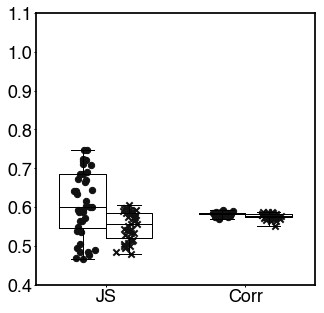

In [29]:

colors = ['#111111', '#111111', '#111111', '#111111']
marker_style = ['o', 'x', 'o', 'x']
colors = np.tile(['#111111', '#111111'], 2)
marker_style = np.tile(['o', 'x'], 2)
(fig, pos) = grouped_boxplot_with_scatter(test, order=range(4), ngroups=2, labels=['JS', 'Corr'], colors=colors, scatter_style=marker_style, figsize=(5,5), marker_size=40)


# significance_bar(pos[0],pos[1], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[0], pos[2], 1.03, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[2], pos[3], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')

# significance_bar(pos[4],pos[5], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[4], pos[6], 1.03, '***',  linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
# significance_bar(pos[6], pos[7], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
plt.ylim([0.40, 1.1])

plt.savefig(os.path.join(figsavepth, 'B1083_Split_JSDIVSTATS.pdf'))

In [32]:
from scipy.stats import ttest_ind
ttests =[(0,1), (0, 2), (2,3)]
ttest_names = ['Pop1JS-Shuffle', 'Pop1JS-Pop1Corr', 'Pop1Corr-Shuffle']
for t, n in zip(ttests, ttest_names):
    res = ttest_ind(test[t[0]], test[t[1]], equal_var=False)
    print('TEST: {}'.format(n))
    print(res)

TEST: Pop1JS-Shuffle
Ttest_indResult(statistic=3.9440678662583397, pvalue=0.00023632733695164103)
TEST: Pop1JS-Pop1Corr
Ttest_indResult(statistic=1.9663849226061356, pvalue=0.056362710846148766)
TEST: Pop1Corr-Shuffle
Ttest_indResult(statistic=5.108509031906927, pvalue=2.9617701602884057e-06)


In [9]:
# Now for correlation
f_fam_orig_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_*.pkl')
f_fam_shuff_reps = glob.glob('/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_shuff_split_*.pkl')
print(f_fam_orig_reps)
print(f_fam_shuff_reps)
from tqdm import tqdm
scsv_reps = []
scsv_shuff = []
for f_fam_orig, f_fam_shuff in tqdm(zip(f_fam_orig_reps, f_fam_shuff_reps)):
    

    with open(f_fam_orig, 'rb') as f:
        div = pickle.load(f)

    with open(f_fam_shuff, 'rb') as f:
        divs = pickle.load(f)



    dataset = build_lmm_dataset(div)
    dataset_s = build_lmm_dataset(divs)

    csss = [dataset, dataset_s]
    #csss = [dataset]

    scsv = []
    for ds in tqdm(csss):

        N_tests = 240
        train_pct = 0.8
        test_pct = 1 - train_pct
        targ = ds['cond'].values
        feat = ds['JS'].values
        scores = []
        for test in range(N_tests):
            ntarg = int(train_pct*len(targ))
            perm = np.random.permutation(np.arange(len(targ)))
            targ_train = targ[perm[0:ntarg]]
            feat_train = feat[perm[0:ntarg]][:, np.newaxis]
            targ_test = targ[perm[ntarg:]]
            feat_test = feat[perm[ntarg:]][:, np.newaxis]
            lr = LogisticRegression()
            lr.fit(feat_train, targ_train)

            scores.append(lr.score(feat_test, targ_test))
        scsv.append(scores)
    scsv_reps.append(scsv)



0it [00:00, ?it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

['/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_37.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_29.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_36.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_28.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_22.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_39.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_10.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_21.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_34.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_0.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_7.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_11.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_9.pkl', '/home/brad/DailyLog/20200123/new2_Correl_B1083_fam_orig_split_5.p


100%|██████████| 2/2 [00:12<00:00,  6.25s/it]
1it [00:12, 12.51s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
2it [00:24, 12.46s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.22s/it]
3it [00:37, 12.46s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.22s/it]
4it [00:49, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.19s/it]
5it [01:02, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
6it [01:14, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.23s/it]
7it [01:27, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.23s/it]
8it [01:39, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.22s/it]
9it [01:51, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
10it [02:04, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.26s/it]
11it [02:16, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.22s/it]
12it [02:29, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.19s/it]
13it [02:41, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.34s/it]
14it [02:54, 12.46s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.23s/it]
15it [03:06, 12.46s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.19s/it]
16it [03:19, 12.46s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.21s/it]
17it [03:31, 12.46s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.21s/it]
18it [03:44, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
19it [03:56, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.21s/it]
20it [04:09, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.21s/it]
21it [04:21, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.17s/it]
22it [04:33, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.18s/it]
23it [04:46, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.22s/it]
24it [04:58, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.16s/it]
25it [05:10, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
26it [05:23, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.29s/it]
27it [05:35, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.25s/it]
28it [05:48, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
29it [06:00, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.18s/it]
30it [06:13, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
31it [06:25, 12.44s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.36s/it]
32it [06:38, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.29s/it]
33it [06:50, 12.45s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.39s/it]
34it [07:03, 12.46s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.47s/it]
35it [07:16, 12.48s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.33s/it]
36it [07:29, 12.48s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
37it [07:41, 12.48s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
38it [07:54, 12.48s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.18s/it]
39it [08:06, 12.48s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.19s/it]
40it [08:18, 12.47s/it]
  0%|          | 0/2 [00:00<?, ?it/s]

(4800,)
(4800,)



100%|██████████| 2/2 [00:12<00:00,  6.21s/it]
41it [08:31, 12.47s/it]


TypeError: list indices must be integers or slices, not range

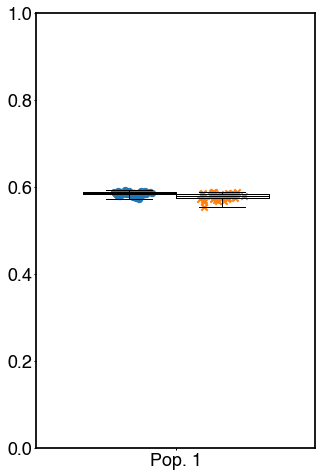

In [11]:
f = lambda x: [np.mean(x[0]), np.mean(x[1])]
test = np.transpose(list(map(f, scsv_reps)))

colors = ['#111111', '#111111']
marker_style = ['o', 'x']
(fig, pos) = grouped_boxplot_with_scatter(test, order=range(2), ngroups=1, labels=['Pop. 1'], colors=colors, scatter_style=marker_style, figsize=(5,8), marker_size=40)


significance_bar(pos[0],pos[1], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[0], pos[2], 1.03, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[2], pos[3], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')

significance_bar(pos[4],pos[5], 0.97 , '***',linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[4], pos[6], 1.03, '***',  linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
significance_bar(pos[6], pos[7], 0.97, '***', linewidth = 1,markersize = 8,boxpad  =0.01,fontsize = 26,color = 'k')
plt.ylim([0.30, 1.1])

plt.savefig(os.path.join(figsavepth, 'B1083_Split_CorrDIVSTATS.pdf'.format(correlation_type)))

In [12]:
from scipy.stats import ttest_ind
ttests =[(0,1)]
ttest_names = ['Pop1JS-Shuffle']
for t, n in zip(ttests, ttest_names):
    res = ttest_ind(test[t[0]], test[t[1]])
    print('TEST: {}'.format(n))
    print(res)

TEST: Pop1JS-Shuffle
Ttest_indResult(statistic=5.534185047653182, pvalue=3.838314688195683e-07)
